In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/EVA5/Picasso

/content/drive/My Drive/EVA5/Picasso


In [3]:
# !git clone https://github.com/anubhabPanda/Picasso.git
!git pull

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 3), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (11/11), done.
From https://github.com/anubhabPanda/Picasso
   68b4813..52378c4  master     -> origin/master
Updating 68b4813..52378c4
Fast-forward
 .gitignore            |   4 +-
 gradcam/__init__.py   |   3 +
 gradcam/gradcam.py    |  79 +++++++
 gradcam/gradcam_pp.py |  49 ++++
 gradcam/visual.py     | 178 ++++++++++++++
 lr_finder.py          | 637 ++++++++++++++++++++++++++++++++++++++++++++++++++
 save_load.py          |   6 +-
 utils.py              |  42 +++-
 8 files changed, 994 insertions(+), 4 deletions(-)
 create mode 100644 gradcam/__init__.py
 create mode 100644 gradcam/gradcam.py
 create mode 100644 gradcam/gradcam_pp.py
 create mode 100644 gradcam/visual.py
 create mode 100644 lr_finder.py


In [4]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 8.0MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=1cfa870107dd25bf940db88fa32b63320d7e3eb5cb86c53f61678d63111f96f5
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import os
import utils
import dataset1
import engine
from models import resnet
import config
import torchvision.datasets as datasets
import cuda
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import albumentations as A
import save_load
import matplotlib.pyplot as plt
from gradcam import GradCAMView
from lr_finder import LRFinder

In [6]:
cuda, device = cuda.initialize_cuda(config.SEED)

GPU Available? True


In [7]:
trainset = dataset1.torch_datasets(True, True, dataset_name='cifar10')
testset = dataset1.torch_datasets(False, True, dataset_name='cifar10')

Files already downloaded and verified
Files already downloaded and verified


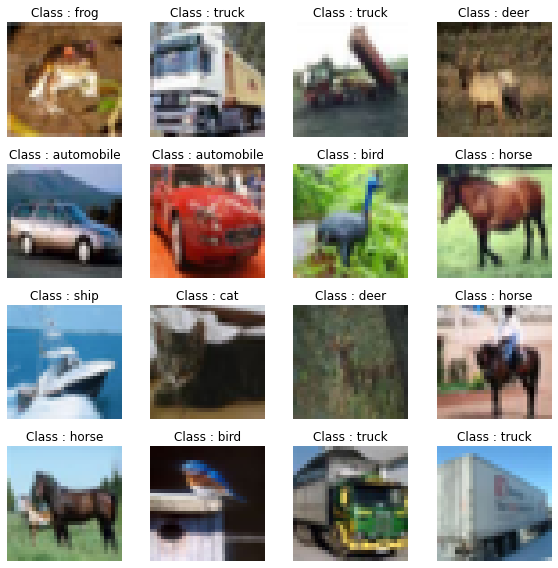

In [8]:
utils.show_imgs(trainset, 16, (8, 8))

In [9]:
mean, std = utils.get_stats(trainset)[0], utils.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [10]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [A.Rotate(15), 
                      A.HorizontalFlip(),
                      A.Cutout(1, 16, 16, fill_value=mean, p=0.3)]

In [11]:
trainset = dataset1.torch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset1.torch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset1.data_loader(trainset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset1.data_loader(testset, config.BATCH_SIZE, config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


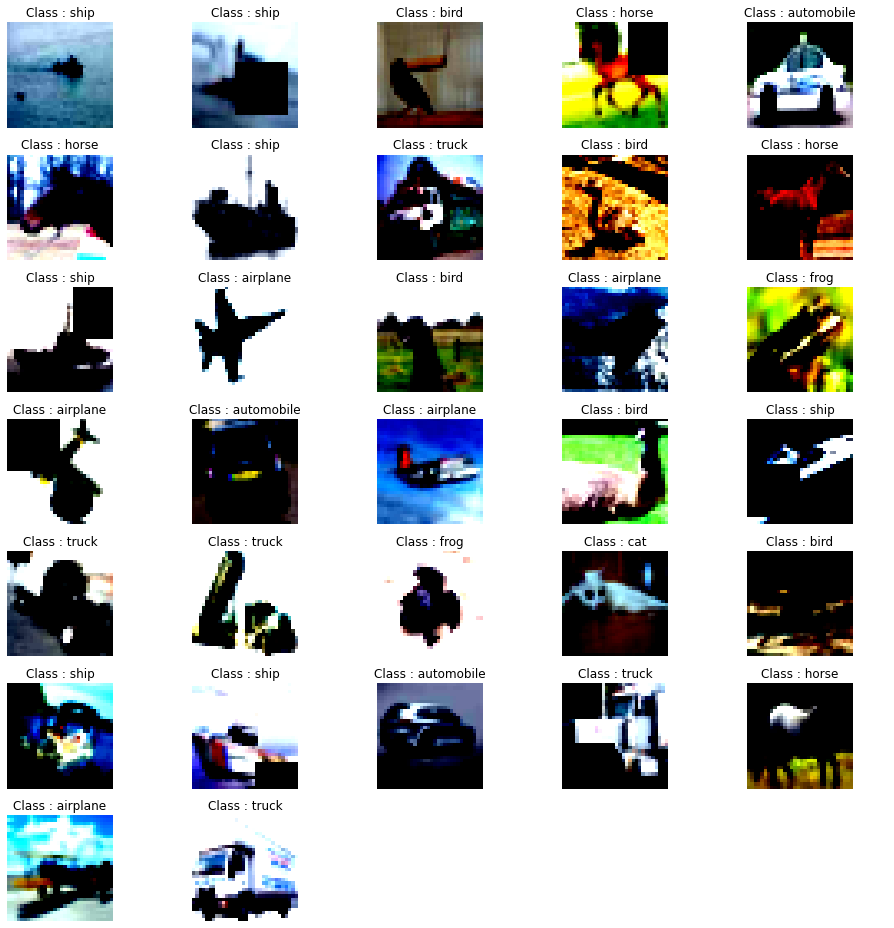

In [12]:
utils.show_batch(train_dl, (13, 13))

In [13]:
#Define model
model = resnet.ResNet18().to(device)

In [14]:
utils.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [15]:
model = resnet.ResNet18().to(device)
loss_fn = utils.cross_entropy_loss_fn()
optimizer = utils.sgd_optimizer(model)
scheduler = utils.StepLR_scheduler(optimizer, step_size=6)
if config.DEBUG == True:
    config.EPOCHS = 30

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{config.EPOCHS}\n")
    engine.train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    engine.test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    scheduler.step()

  0%|          | 0/1563 [00:00<?, ?it/s]

Running Epoch 1/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0354, Accuracy: 5993/10000 (59.93%)

Running Epoch 2/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0252, Accuracy: 7209/10000 (72.09%)

Running Epoch 3/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0207, Accuracy: 7731/10000 (77.31%)

Running Epoch 4/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0181, Accuracy: 8037/10000 (80.37%)

Running Epoch 5/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0173, Accuracy: 8213/10000 (82.13%)

Running Epoch 6/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0154, Accuracy: 8294/10000 (82.94%)

Running Epoch 7/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0120, Accuracy: 8697/10000 (86.97%)

Running Epoch 8/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0116, Accuracy: 8745/10000 (87.45%)

Running Epoch 9/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0114, Accuracy: 8770/10000 (87.70%)

Running Epoch 10/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0112, Accuracy: 8803/10000 (88.03%)

Running Epoch 11/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0114, Accuracy: 8797/10000 (87.97%)

Running Epoch 12/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0110, Accuracy: 8797/10000 (87.97%)

Running Epoch 13/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0108, Accuracy: 8840/10000 (88.40%)

Running Epoch 14/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0108, Accuracy: 8836/10000 (88.36%)

Running Epoch 15/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0109, Accuracy: 8849/10000 (88.49%)

Running Epoch 16/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0108, Accuracy: 8846/10000 (88.46%)

Running Epoch 17/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0108, Accuracy: 8844/10000 (88.44%)

Running Epoch 18/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0109, Accuracy: 8853/10000 (88.53%)

Running Epoch 19/20



  0%|          | 0/1563 [00:00<?, ?it/s]


Validation set: Average loss: 0.0108, Accuracy: 8863/10000 (88.63%)

Running Epoch 20/20



Loss=0.13 Batch_ID=1562 Accuracy=91.36: 100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



Validation set: Average loss: 0.0107, Accuracy: 8839/10000 (88.39%)



In [16]:
#Saving Model
save_load.save_model(model, "EVA5S9.pth")

Model saving successful


# Gradcam

In [17]:
one_batch = next(iter(test_dl))[0]
batch_imgs = []

for i in range(len(one_batch)):
    if i < 25:
        batch_imgs.append(one_batch[i])

Mode set to GradCAM.


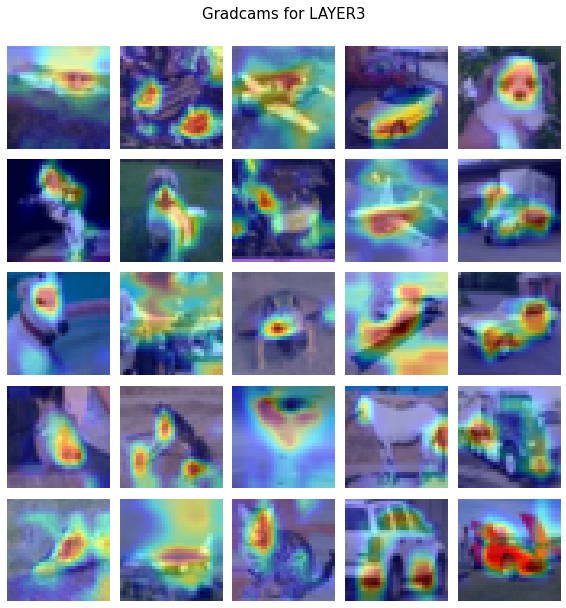

<Figure size 432x288 with 0 Axes>

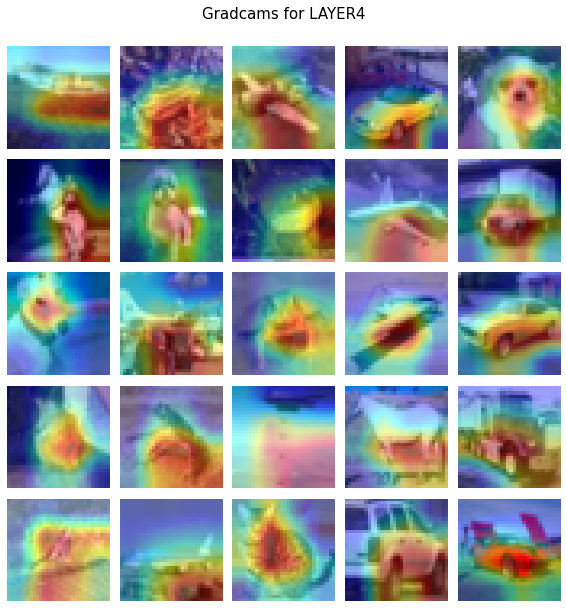

<Figure size 432x288 with 0 Axes>

In [18]:
grad_cam = GradCAMView(
    model, ['layer3', 'layer4'],
    device, mean, std
)
image = batch_imgs
grad_cam(image, 'grad_cam', (8,8))

# Misclassified Images

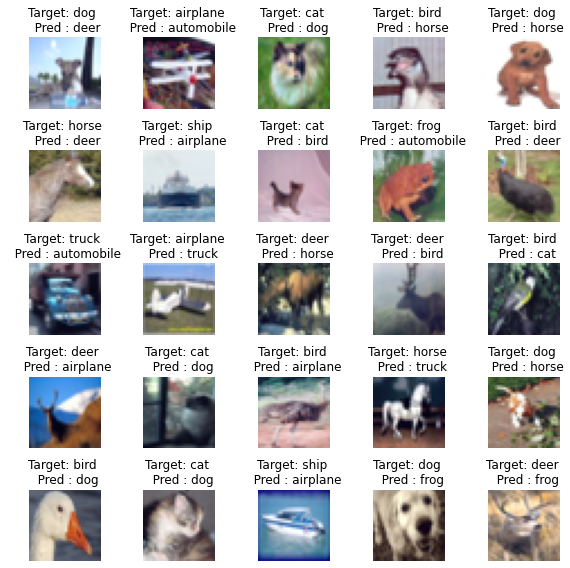

In [20]:
class_idx = trainset.class_to_idx
utils.plot_incorrect_images(misclassified_imgs, class_idx, plot_size=(8, 8))

# Validation Plots

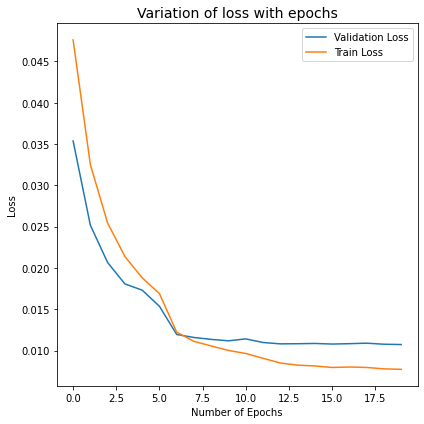

In [21]:
utils.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

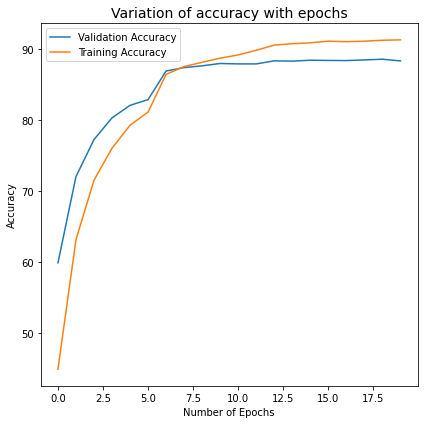

In [22]:
utils.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")